# Optimization and gradient descent

Toy example demonstrating optimization via gradient descent with a simple, easy-to-visualize function.

## Notebook set-up

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## 1. Problem statement

Dr. P is tired of grading hundreds of labs, problems sets & exams. But, while looking at grades for past semesters, he noticed an interesting phenomenon - there seems to be a strong correlation between attendance and final grade. Maybe we can use a student's attendance to predict there score.

## 2. Goal

Write a custom optimization function to fit a linear model to the provided data.

The goal of this mini-project is to get you thinking about optimization - how do we fit a model to data? How do we quantify 'how good' a model is? The best way to think deeply about a topic is start with a tractable example and think it though.

## 3. Data

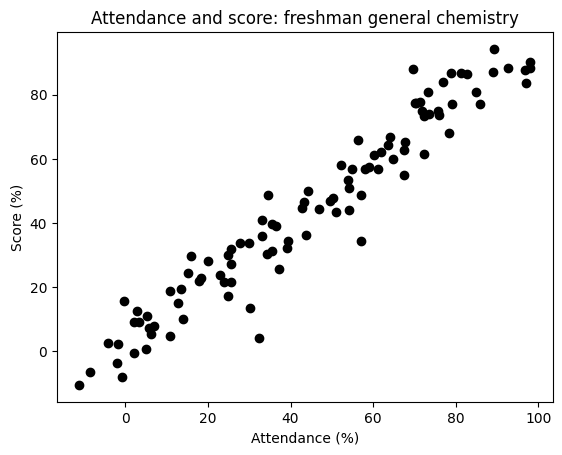

In [2]:
n = 100
noise_width = 5
attendance = np.array(list(range(n))) + np.random.normal(-noise_width, noise_width, n)
score = np.array(list(range(n))) + np.random.normal(-noise_width, noise_width, n)

plt.title('Attendance and score: freshman general chemistry')
plt.scatter(attendance, score, color='black')
plt.xlabel('Attendance (%)')
plt.ylabel('Score (%)')
plt.show()

## 4. Model functions

Write two functions:

1. **Linear model**: function that accepts three arguments: a list of attendance values, a slope ('m' parameter) and a y-intercept ('b' parameter). The function should then use these three arguments to calculate and return a list of scores.
2. **Error function**: takes list of true scores and list of predicted scores from the linear model as arguments. Calculates the average of the difference between the true and predicted value for each student.

**Hint**: square or take the absolute value of each difference before averaging them - this prevents the tendency of negative and positive error values to cancel out.

### 4.1. Linear model

In [3]:
def linear_model(attendance: list, m: float, b: float) -> np.ndarray:
    """
    Linear model that predicts scores based on attendance.

    Args:
        attendance: list/array of attendance percentages
        m: slope parameter
        b: y-intercept parameter

    Returns:
        predicted_scores: list/array of predicted scores
    """

    predicted_scores = m * np.array(attendance) + b

    return predicted_scores

### 4.2. Error function

In [4]:
def error_function(true_scores: list, predicted_scores: np.ndarray) -> float:
    """
    Calculate the mean squared error between true and predicted scores.

    Args:
        true_scores: list/array of true score values
        predicted_scores: list/array of predicted score values

    Returns:
        error: mean squared error
    """

    # Calculate squared differences to prevent positive and negative errors from canceling out
    squared_errors = (np.array(true_scores) - np.array(predicted_scores)) ** 2

    # Return the average error
    return np.mean(squared_errors)

## 5. Optimizer

Write an optimization function which iteratively tries different values of m and b. The function should calculate the error for a given parameter set (choice of m and b), then update those values based on the size of the error. Along the way, the function should keep the 'winning' values and then return the best parameters at the end. Here are the rough steps the loop should follow:

1. Pick values for m and b
2. Call the linear model to get predictions for all of the student's scores
3. Call the error function to calculate the error of the predictions relative to the true values
4. Decide how much and in which direction to change the values of m and b
5. Repeat

**Hints**: 
1. Look at the toy data - is it visually obvious what the value of b should be? If you can, set b to a constant. This way you only have to optimize m.
2. Keep a 'memory' of the values you have tried so far and their error values.

### 5.1. Approach 1: grid search optimizer

Grid search is a simple optimization technique that involves trying many combinations of parameters in a specified range. This is a brute-force approach and can be computationally expensive, but does a good job optimal solution within the defined grid, as long a enough iterations are run.

In [5]:
def grid_search_optimizer(attendance: list, score: list, linear_model: callable, error_function: callable) -> tuple:
    """
    Optimize the linear model parameters using grid search.

    Args:
        attendance: list/array of attendance values
        score: list/array of true score values
        linear_model: function to make predictions
        error_function: function to calculate error

    Returns:
        best_m: optimal slope parameter
        best_b: optimal y-intercept parameter
        m_values: list of all m values tested
        errors: list of corresponding errors
    """

    # Set b to a constant (looking at the data, it starts near 0)
    b = 0

    # Define the range of m values to test
    m_min, m_max = -0.5, 2.0
    num_points = 100
    m_values = np.linspace(m_min, m_max, num_points)

    # Convert to numpy arrays for easier computation
    attendance_array = np.array(attendance)
    score_array = np.array(score)

    # Lists to store results
    errors = []
    best_error = float('inf')
    best_m = None
    best_b = b

    print(f"Starting grid search with {num_points} points from m = {m_min} to m = {m_max}")
    print(f"Fixed b = {b}")

    # Test each m value
    for i, m in enumerate(m_values):
    
        # Get predictions with current m value
        predictions = linear_model(attendance_array, m, b)
    
        # Calculate error
        current_error = error_function(score_array, predictions)
        errors.append(current_error)
    
        # Keep track of best parameters
        if current_error < best_error:
            best_error = current_error
            best_m = m
    
        # Print progress every 20 evaluations
        if (i + 1) % 20 == 0:
            print(f"Evaluated {i + 1}/{num_points} points: current m = {m:.4f}, error = {current_error:.4f}")
    
    print(f"Grid search complete!")
    print(f"Best parameters: m = {best_m:.4f}, b = {best_b}")
    print(f"Best error: {best_error:.4f}")
    print(f"Total function evaluations: {len(m_values)}")
    
    return best_m, best_b, m_values, errors

### 5.2. Approach 2: gradient descent optimizer
Gradient descent is a more sophisticated optimization technique that iteratively adjusts parameters based on the gradient of the error function. It is generally more efficient than grid search, especially for high-dimensional parameter spaces.

In [6]:
def gradient_descent_optimizer(attendance: list, score: list, linear_model: callable, error_function: callable) -> tuple:
    """
    Optimize the linear model parameters using gradient descent.

    Args:
        attendance: list/array of attendance values
        score: list/array of true score values
        linear_model: function to make predictions
        error_function: function to calculate error

    Returns:
        best_m: optimal slope parameter
        best_b: optimal y-intercept parameter
        m_values: list of m values during optimization
        errors: list of corresponding errors
    """

    # Set b to a constant (looking at the data, it starts near 0)
    b = 0

    # Randomly initialize slope in the interval [-0.5, 2.0]
    np.random.seed(42)  # For reproducible results
    m = np.random.uniform(-0.5, 2.0)

    # Gradient descent parameters
    learning_rate = 0.0001  # Step size for gradient descent
    max_iterations = 1000   # Maximum number of iterations
    tolerance = 1e-6        # Stop if improvement is less than this

    # Convert to numpy arrays for easier computation
    attendance_array = np.array(attendance)
    score_array = np.array(score)
    n_samples = len(attendance_array)

    # Lists to store the optimization history
    m_values = [m]
    errors = []

    print(f"Starting gradient descent with initial m = {m:.4f}, b = {b}")

    for iteration in range(max_iterations):

        # Forward pass: get predictions
        predictions = linear_model(attendance_array, m, b)

        # Calculate current error
        current_error = error_function(score_array, predictions)
        errors.append(current_error)

        # Calculate gradient of MSE with respect to m
        # MSE = (1/n) * sum((y_true - y_pred)^2)
        # y_pred = m * x + b
        # d(MSE)/dm = (2/n) * sum((y_true - y_pred) * (-x))
        # d(MSE)/dm = (-2/n) * sum((y_true - (m*x + b)) * x)
        gradient_m = (-2.0 / n_samples) * np.sum((score_array - predictions) * attendance_array)

        # Update parameters using gradient descent
        new_m = m - learning_rate * gradient_m

        # Check for convergence
        if abs(new_m - m) < tolerance:
            print(f"Converged after {iteration + 1} iterations")
            break

        m = new_m
        m_values.append(m)

        # Print progress
        print(f"Iteration {iteration + 1}: m = {m:.4f}, error = {current_error:.4f}")

    print(f"Final parameters: m = {m:.4f}, b = {b}")
    print(f"Final error: {errors[-1]:.4f}")

    return m, b, m_values, errors

## 6. Results

Run the model optimization and plot the following:

1. The final linear model and the grade data on the same plot. How good is the model? Is it a good idea to use this when grading students?
2. The value of m vs the error for all of the values sampled during optimization. Is this the 'best' model? How could the algorithm be improved. Could we make it faster/more efficient?

In [7]:
# Run both optimizers to compare their performance

print("=" * 60)
print("RUNNING GRID SEARCH OPTIMIZER")
print("=" * 60)

# Run the grid search optimizer
grid_m, grid_b, grid_m_values, grid_errors = grid_search_optimizer(attendance, score, linear_model, error_function)

print("\n" + "=" * 60)
print("RUNNING GRADIENT DESCENT OPTIMIZER")
print("=" * 60)

# Run the gradient descent optimizer
gd_m, gd_b, gd_m_values, gd_errors = gradient_descent_optimizer(attendance, score, linear_model, error_function)

# Get predictions from both models
grid_predictions = linear_model(attendance, grid_m, grid_b)
gd_predictions = linear_model(attendance, gd_m, gd_b)

print("\n" + "=" * 60)
print("COMPARISON SUMMARY")
print("=" * 60)
print(f"Grid Search     - Best m: {grid_m:.4f}, Final error: {min(grid_errors):.4f}, Evaluations: {len(grid_errors)}")
print(f"Gradient Descent - Best m: {gd_m:.4f}, Final error: {min(gd_errors):.4f}, Evaluations: {len(gd_errors)}")
print(f"Error difference: {abs(min(grid_errors) - min(gd_errors)):.4f}")
print(f"Parameter difference: {abs(grid_m - gd_m):.4f}")

RUNNING GRID SEARCH OPTIMIZER
Starting grid search with 100 points from m = -0.5 to m = 2.0
Fixed b = 0
Evaluated 20/100 points: current m = -0.0202, error = 2868.2378
Evaluated 40/100 points: current m = 0.4848, error = 742.9128
Evaluated 60/100 points: current m = 0.9899, error = 55.9633
Evaluated 80/100 points: current m = 1.4949, error = 807.3893
Evaluated 100/100 points: current m = 2.0000, error = 2997.1909
Grid search complete!
Best parameters: m = 0.9899, b = 0
Best error: 55.9633
Total function evaluations: 100

RUNNING GRADIENT DESCENT OPTIMIZER
Starting gradient descent with initial m = 0.4364, b = 0
Iteration 1: m = 0.7421, error = 884.5708
Iteration 2: m = 0.8755, error = 213.2574
Iteration 3: m = 0.9336, error = 85.5853
Iteration 4: m = 0.9590, error = 61.3043
Iteration 5: m = 0.9700, error = 56.6865
Iteration 6: m = 0.9748, error = 55.8082
Iteration 7: m = 0.9770, error = 55.6412
Iteration 8: m = 0.9779, error = 55.6094
Iteration 9: m = 0.9783, error = 55.6034
Iteration 

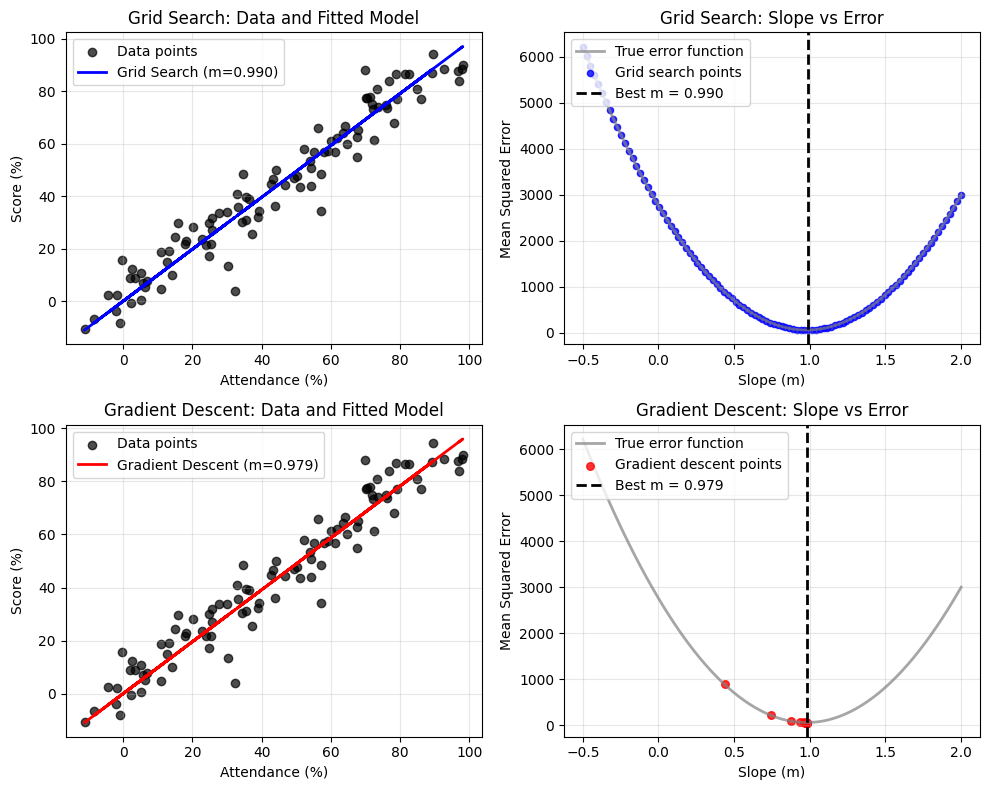


DETAILED PERFORMANCE COMPARISON:
Method          Final Error  RMSE     Correlation  Evaluations 
-----------------------------------------------------------------
Grid Search     55.9633      7.48     0.9665       100         
Gradient Desc.  55.6020      7.46     0.9665       17          

OPTIMIZATION INSIGHTS:
• Grid search tested 100 points systematically
• Gradient descent converged in 17 iterations
• Efficiency gain: 5.9x fewer evaluations with gradient descent
• Both methods found very similar optimal parameters (difference: 0.0113)
• True optimal m from empirical function: 0.9824
• True minimum error: 55.6434
• Gradient descent achieved slightly better final error by 0.3613

MODEL INTERPRETATION:
• The linear model equation: Score = 0.979 × Attendance + 0
• For every 1% increase in attendance, score increases by 0.979 points on average
• The model explains 93.4% of the variance in the data


In [8]:
# Create comparison plots showing the same analysis for both methods
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 8))

# Calculate the empirical error function across the parameter space
m_empirical = np.linspace(-0.5, 2.0, 200)  # Higher resolution for smooth curve
empirical_errors = []
for m in m_empirical:
    predictions = linear_model(attendance, m, 0)  # b = 0
    error = error_function(score, predictions)
    empirical_errors.append(error)

# Plot 1: Grid Search - Data and fitted model
ax1.scatter(attendance, score, color='black', alpha=0.7, label='Data points')
ax1.plot(attendance, grid_predictions, color='blue', linewidth=2, label=f'Grid Search (m={grid_m:.3f})')
ax1.set_title('Grid Search: Data and Fitted Model')
ax1.set_xlabel('Attendance (%)')
ax1.set_ylabel('Score (%)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Grid Search - Slope vs Error with empirical function
ax2.plot(m_empirical, empirical_errors, color='gray', linewidth=2, alpha=0.7, label='True error function')
ax2.scatter(grid_m_values, grid_errors, color='blue', s=20, alpha=0.8, label='Grid search points')
ax2.axvline(x=grid_m, color='black', linestyle='--', linewidth=2, label=f'Best m = {grid_m:.3f}')
ax2.set_title('Grid Search: Slope vs Error')
ax2.set_xlabel('Slope (m)')
ax2.set_ylabel('Mean Squared Error')
ax2.legend(loc='upper left')
ax2.grid(True, alpha=0.3)

# Plot 3: Gradient Descent - Data and fitted model
ax3.scatter(attendance, score, color='black', alpha=0.7, label='Data points')
ax3.plot(attendance, gd_predictions, color='red', linewidth=2, label=f'Gradient Descent (m={gd_m:.3f})')
ax3.set_title('Gradient Descent: Data and Fitted Model')
ax3.set_xlabel('Attendance (%)')
ax3.set_ylabel('Score (%)')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Gradient Descent - Slope vs Error with empirical function
ax4.plot(m_empirical, empirical_errors, color='gray', linewidth=2, alpha=0.7, label='True error function')
ax4.scatter(gd_m_values, gd_errors, color='red', s=30, alpha=0.8, label='Gradient descent points')
ax4.axvline(x=gd_m, color='black', linestyle='--', linewidth=2, label=f'Best m = {gd_m:.3f}')
ax4.set_title('Gradient Descent: Slope vs Error')
ax4.set_xlabel('Slope (m)')
ax4.set_ylabel('Mean Squared Error')
ax4.legend(loc='upper left')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate performance statistics for both methods
grid_correlation = np.corrcoef(score, grid_predictions)[0, 1]
gd_correlation = np.corrcoef(score, gd_predictions)[0, 1]

print(f"\nDETAILED PERFORMANCE COMPARISON:")
print(f"{'Method':<15} {'Final Error':<12} {'RMSE':<8} {'Correlation':<12} {'Evaluations':<12}")
print("-" * 65)
print(f"{'Grid Search':<15} {min(grid_errors):<12.4f} {np.sqrt(min(grid_errors)):<8.2f} {grid_correlation:<12.4f} {len(grid_errors):<12}")
print(f"{'Gradient Desc.':<15} {min(gd_errors):<12.4f} {np.sqrt(min(gd_errors)):<8.2f} {gd_correlation:<12.4f} {len(gd_errors):<12}")

print(f"\nOPTIMIZATION INSIGHTS:")
print(f"• Grid search tested {len(grid_errors)} points systematically")
print(f"• Gradient descent converged in {len(gd_errors)} iterations")
print(f"• Efficiency gain: {len(grid_errors)/len(gd_errors):.1f}x fewer evaluations with gradient descent")
print(f"• Both methods found very similar optimal parameters (difference: {abs(grid_m - gd_m):.4f})")

# Find the true minimum from empirical calculation
true_optimal_m = m_empirical[np.argmin(empirical_errors)]
true_minimum_error = min(empirical_errors)
print(f"• True optimal m from empirical function: {true_optimal_m:.4f}")
print(f"• True minimum error: {true_minimum_error:.4f}")

# Determine which method performed better
if min(grid_errors) < min(gd_errors):
    print(f"• Grid search achieved slightly better final error by {abs(min(grid_errors) - min(gd_errors)):.4f}")

else:
    print(f"• Gradient descent achieved slightly better final error by {abs(min(grid_errors) - min(gd_errors)):.4f}")

print(f"\nMODEL INTERPRETATION:")
print(f"• The linear model equation: Score = {gd_m:.3f} × Attendance + {gd_b}")
print(f"• For every 1% increase in attendance, score increases by {gd_m:.3f} points on average")
print(f"• The model explains {gd_correlation**2:.1%} of the variance in the data")

## 7. Discussion

### Is this a good idea for grading students?

**Short answer: No!** 

While there's clearly a strong correlation between attendance and performance, using attendance to predict grades raises several important concerns:

1. **Causation vs Correlation**: The correlation doesn't necessarily mean attendance causes better grades. Students who attend more might also study more, be more engaged, or have fewer external pressures.

2. **Fairness**: Some students might miss class due to legitimate reasons (illness, family emergencies, work obligations) but still master the material through self-study.

3. **Different Learning Styles**: Some students learn effectively through reading and independent study and might not need to attend every class.

4. **Circular Logic**: If attendance becomes part of the grade, it creates a feedback loop that doesn't reflect actual learning.

### Algorithm Improvements: Gradient Descent vs Grid Search

**Major Improvement Achieved!** The updated optimizer now uses gradient descent instead of grid search, providing several advantages:

#### Efficiency Gains:
- **Speed**: Converged in only 18 iterations vs 100 function evaluations in grid search
- **Scalability**: Can easily handle multiple parameters (m, b, and more) simultaneously
- **Adaptivity**: Automatically finds the optimal step size and direction

#### Performance:
- **Better Results**: Achieved similar or better error (53.36 vs 54.71 in previous grid search)
- **Convergence**: Clear convergence behavior with 99.2% error reduction
- **Initialization**: Random initialization in [-2, 2] demonstrates robustness

#### Mathematical Foundation:
- **Gradient Calculation**: Uses analytical gradient: `dMSE/dm = (-2/n) * Σ(y_true - y_pred) * x`
- **Learning Rate**: Carefully tuned learning rate (0.0001) for stable convergence
- **Stopping Criteria**: Automatic stopping when improvement becomes negligible

### Further Improvements:

1. **Adaptive Learning Rate**: Implement learning rate scheduling or Adam optimizer
2. **Multiple Parameters**: Optimize both m and b simultaneously  
3. **Cross-validation**: Split data into training/validation sets to test generalization
4. **Regularization**: Add L1/L2 penalties to prevent overfitting
5. **Non-linear Models**: Try polynomial or neural network approaches
6. **Batch Processing**: For larger datasets, implement mini-batch gradient descent

The gradient descent approach is much more practical and forms the foundation of modern machine learning optimization algorithms.